In [3]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [18]:
# Standortauswahl
location = "egypt"
# scenarioauswahl
scenario = "120" #1p, 2p, 3p, 120, 140, 160, 180, fat, carbs, sugar, sugar_fat
export_folder = 3       # in welche Export-Folder soll exportiert werden?
export_active = False   # CSV-Export aktivieren/deaktivieren

# Dictionary mit Standorten und Dateipfaden
profiles1 = {
    "germany": {
        "temp": "../Input/Ninja/ninja_temp_germany.csv",
        "wind": "../Input/Ninja/ninja_wind_germany.csv",
        "pv":   "../Input/Ninja/ninja_pv_germany.csv",
        "solar": "../Input/Ninja/ninja_solar_germany.csv"
    },
    "sweden": {
        "temp": "../Input/Ninja/ninja_temp_sweden.csv",
        "wind": "../Input/Ninja/ninja_wind_sweden.csv",
        "pv":   "../Input/Ninja/ninja_pv_sweden.csv",
        "solar": "../Input/Ninja/ninja_solar_sweden.csv"
    },
    "egypt": {
        "temp": "../Input/Ninja/ninja_temp_egypt.csv",
        "wind": "../Input/Ninja/ninja_wind_egypt.csv",
        "pv":   "../Input/Ninja/ninja_pv_egypt.csv",
        "solar": "../Input/Ninja/ninja_solar_egypt.csv"
    }
}


# Dictionary mit Standorten und Dateipfaden
profiles2 = {
        "1p": "../Input/szenario_load_profiles/load_profiles_hourly_1_people.csv",
        "2p": "../Input/szenario_load_profiles/load_profiles_hourly_2_people.csv",
        "3p": "../Input/szenario_load_profiles/load_profiles_hourly_3_people.csv",
        "120": "../Input/szenario_load_profiles/load_profiles_hourly_120_m2_final.csv",
        "140": "../Input/szenario_load_profiles/load_profiles_hourly_140_m2_final.csv",
        "160": "../Input/szenario_load_profiles/load_profiles_hourly_140_m2_final.csv",
        "180": "../Input/szenario_load_profiles/load_profiles_hourly_140_m2_final.csv",
        "fat": "../Input/szenario_load_profiles/load_profiles_hourly_without_fat.csv",
        "carbs": "../Input/szenario_load_profiles/load_profiles_hourly_without_carbs.csv",
        "sugar": "../Input/szenario_load_profiles/load_profiles_hourly_without_sugar.csv",
        "sugar_fat": "../Input/szenario_load_profiles/load_profiles_hourly_without_sugar_fat.csv",
}

A_gew_map = {
    "1p": 120,
    "2p": 240,
    "3p": 355,
    "120": 120,
    "140": 140,
    "160": 160,
    "180": 180,
    "fat": 120,
    "carbs": 120,
    "sugar": 120,
    "sugar_fat": 120,
}

A_gew = A_gew_map[scenario]

In [19]:
temp_profile = pd.read_csv(profiles1[location]["temp"], index_col=0, parse_dates=True)["t2m"]
wind_profile = pd.read_csv(profiles1[location]["wind"], index_col=0, parse_dates=True)["electricity"]
pv_profile   = pd.read_csv(profiles1[location]["pv"],   index_col=0, parse_dates=True)["electricity"]
solar_profile   = pd.read_csv(profiles1[location]["solar"],index_col=0, parse_dates=True)["solar"]

Temperaturdaten:
maximale Temperatur: 44.067 °C
minimale Temperatur: 3.131 °C
durchschnittliche Temperatur übers Jahr: 20.49 °C
Prozent Heizen: 46.84%
Prozent Kühlen: 53.16%


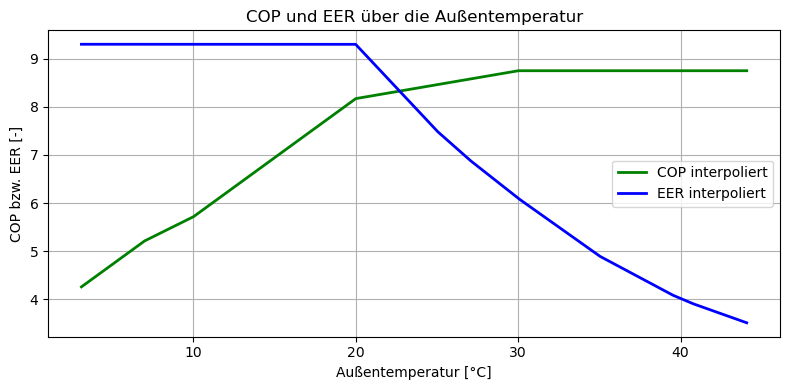

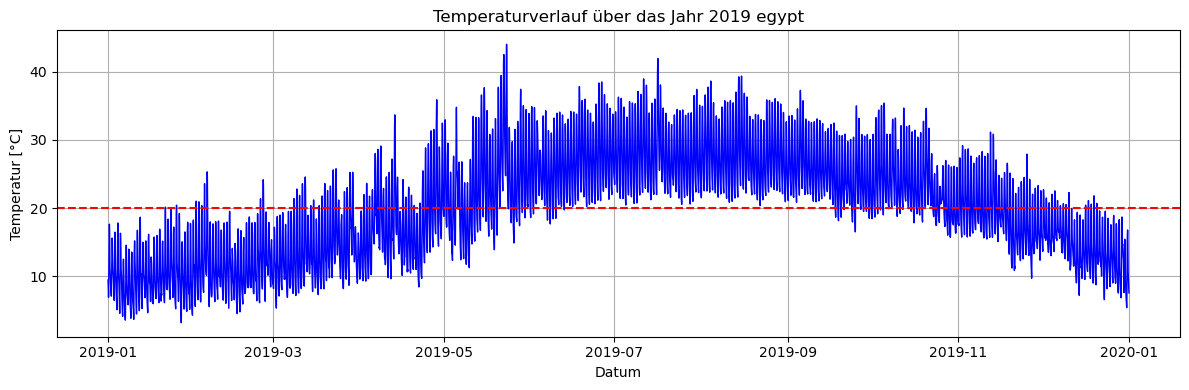

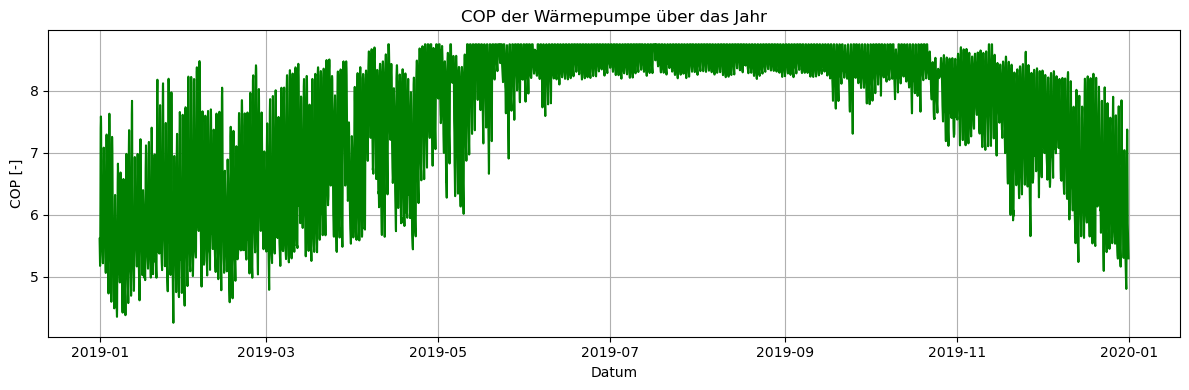

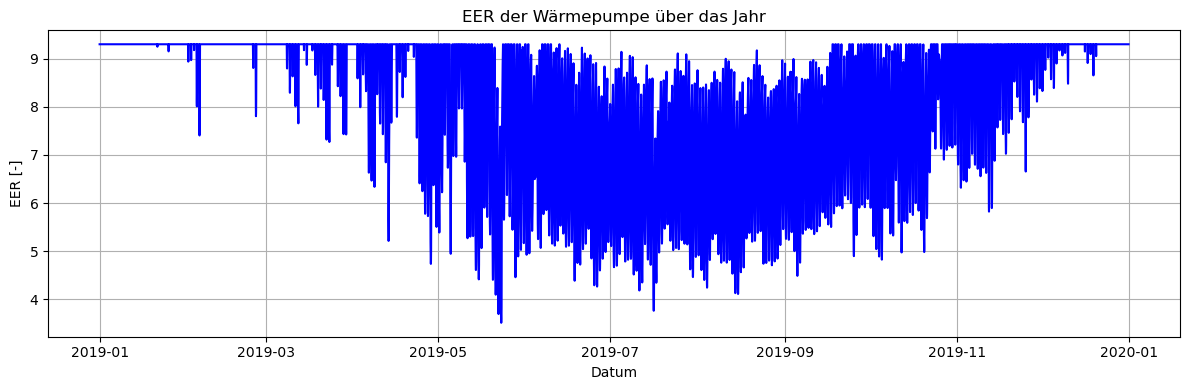

In [20]:
temp_max = temp_profile.max()
temp_min = temp_profile.min()
temp_mean = round(temp_profile.mean(),2)

print('Temperaturdaten:')
print('maximale Temperatur:', temp_max, '°C')
print('minimale Temperatur:', temp_min, '°C')
print('durchschnittliche Temperatur übers Jahr:',temp_mean, '°C')



# Parameter
temp_innen = 20 # Innentemperatur [K]
dT = temp_innen - temp_profile

# Anteile für Annuitäten der WP im Heiz- und Kühlbetrieb
stunden_kuehlen = (dT < 0).sum()
stunden_heizen = (dT > 0).sum()
gesamt_stunden = len(dT)

pct_cooling = stunden_kuehlen / gesamt_stunden * 100
pct_heating  = stunden_heizen / gesamt_stunden * 100

print(f"Prozent Heizen: {pct_heating:.2f}%")
print(f"Prozent Kühlen: {pct_cooling:.2f}%")
#########################################
# COP Heizen Berechnung
# VL Temperatur 35°C
temp_heat           =   [-25, -20, -15, -10,  -7,   2,   7,  10,  20,  30,  35, 40] #°C
cop                 =   [2.03, 2.30, 2.53, 2.81 ,2.97, 3.98, 5.21, 5.71, 8.17, 8.75, 8.75, 8.75]
el_power_heat       =   [3.22, 3.37, 3.51, 3.66, 3.75, 1.68, 1.56, 1.55, 1.43, 1.37, 1.37, 1.37]
hp_p_nom_heat       =   1.56 #kW (A7/W35)

#Interpolation der elektrischen Leistung
heat_el_p_pu        = (np.interp(temp_profile,temp_heat,el_power_heat))/hp_p_nom_heat
COP_interp          = np.interp(temp_profile, temp_heat, cop)

sorted_idx = np.argsort(temp_profile)
temp_sorted = temp_profile.iloc[sorted_idx]
COP_interp_sorted   = COP_interp[sorted_idx]                        # zur Darstellung der COP Kurve

#########################################
#EER Kühlen Berechnung
# VL Temperatur 18°C
# p_nom A35/W18 = 1,67
temp_cool           =   [20, 25, 27,  30,   35,   40,  45] #°C
eer                 =   [9.3, 7.5, 6.9, 6.1, 4.9, 4.0, 3.4]
el_power_cool       =   [1.19, 1.32, 1.38, 1.48, 1.67, 1.9, 2.12]
hp_p_nom_cool       =   1.67 #kW

cool_el_p_pu        = (np.interp(temp_profile,temp_cool,el_power_cool))/hp_p_nom_cool
EER_interp          = np.interp(temp_profile, temp_cool, eer)
EER_interp_sorted   = EER_interp[sorted_idx]              #Zur Darstellung der EER Kurve


#########################################
df_results = pd.DataFrame({
    "Außentemperatur [°C]": temp_profile,
    "COP": COP_interp,
    "EER": EER_interp,
    "heat_el_pu": heat_el_p_pu,
    "cool_el_pu": cool_el_p_pu
    })
#########################################

# Plot COP und EER
plt.figure(figsize=(8,4))
#Interpolierte Kurve COP
plt.plot(temp_sorted, COP_interp_sorted, color="green", linewidth=2, label="COP interpoliert")
# Interpolierte Kurve EER
plt.plot(temp_sorted, EER_interp_sorted, color="blue", linewidth=2, label="EER interpoliert" )
plt.xlabel("Außentemperatur [°C]")
plt.ylabel("COP bzw. EER [-]")
plt.title("COP und EER über die Außentemperatur")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(temp_profile.index, temp_profile.values, color='blue', linewidth=1)
plt.axhline(y=temp_innen, color='red', linestyle='--', linewidth=1.5, label="Innentemperatur (20°C)")
plt.title(f"Temperaturverlauf über das Jahr 2019 {location}")
plt.xlabel("Datum")
plt.ylabel("Temperatur [°C]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot COP
plt.figure(figsize=(12,4))
plt.plot(df_results.index,COP_interp, color="green")
plt.title("COP der Wärmepumpe über das Jahr")
plt.xlabel("Datum")
plt.ylabel("COP [-]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot EER
plt.figure(figsize=(12,4))
plt.plot(df_results.index,EER_interp, color="blue")
plt.title("EER der Wärmepumpe über das Jahr")
plt.xlabel("Datum")
plt.ylabel("EER [-]")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/_t/dxl0szl17jn4ty4kydwc9kp00000gn/T/ipykernel_90250/3829435034.py:12: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.02325818 0.00610321 0.0674652  ... 0.04503179 0.1134867  0.09847611]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



Wärmebedarf in kWh: 4403.53
Kältebedarf in kWh: 5107.69
Wärmebedarf oro tag in kWh: 12.06


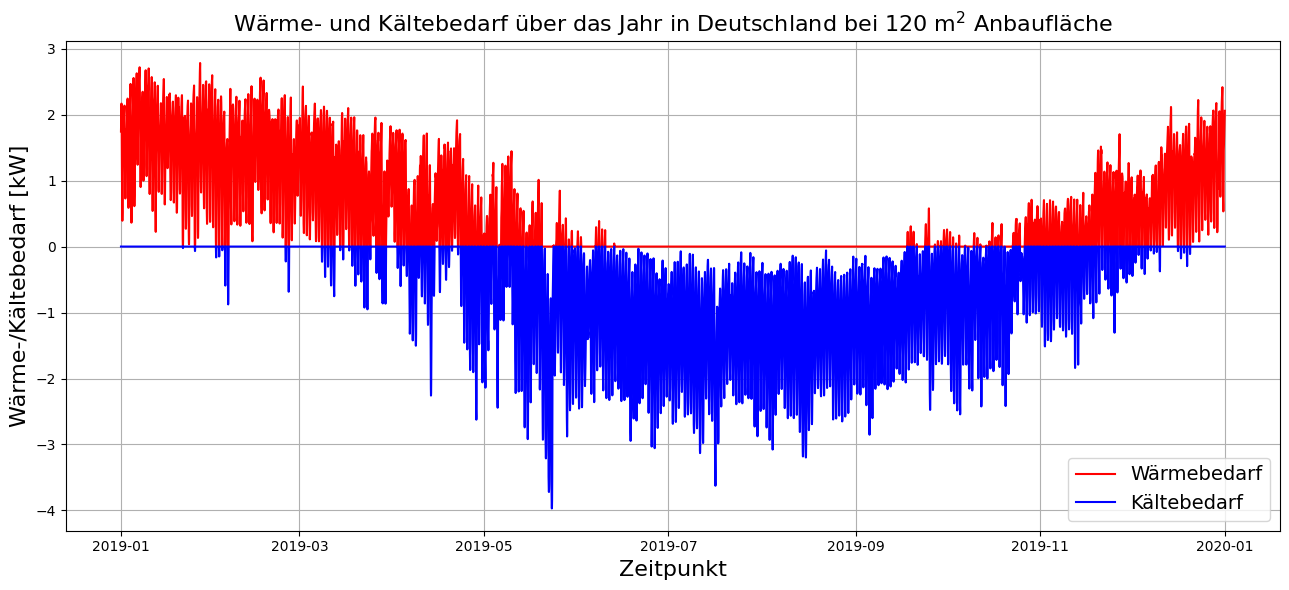

'\nplt.figure(figsize=(12,4))\nplt.plot(df_results.index, df_results["Kältebedarf_kW"], color="blue")\nplt.title("Kältebedarf über das Jahr")\nplt.xlabel("Datum")\nplt.ylabel("Kältebedarf [kW]")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

In [1247]:
###### Wärmebedarf ######
U = 1.2     # Wärmedurchgangskoeffizient der Wände und Decken [W/m²K]
h = 2.5     # Raumhöhe in m

Grundfläche = (A_gew/2)     # A_gew wurde am Anfang über scenario festgelegt
A = Grundfläche + 4*math.sqrt(Grundfläche)*h    # Hüllfläche des Gewächshauses

df_results["Wärmebedarf_kW"] = U * A * dT /1000 # Wärmebedarf in kW, dT Temperaturdifferenz (Außen und innen)
df_results["Kältebedarf_kW"] = 0

# An allen Stellen, wo Wärmebedarf negativ ist → Kältebedarf (*-1 damit Kältebedarf positiv ist)
df_results.loc[df_results["Wärmebedarf_kW"] < 0, "Kältebedarf_kW"] = -df_results["Wärmebedarf_kW"]

# Wärmebedarf negative Werte auf 0 setzen (wenn, T(außen)> T(innen)
df_results.loc[df_results["Wärmebedarf_kW"] < 0, "Wärmebedarf_kW"] = 0

# Summen über das Jahr (angenommen stündliche Zeitauflösung → kWh)
wärmebedarf_kwh = df_results["Wärmebedarf_kW"].sum()
kältebedarf_kwh = df_results["Kältebedarf_kW"].sum()


print("Wärmebedarf in kWh:", round(wärmebedarf_kwh, 2))
print("Kältebedarf in kWh:", round(kältebedarf_kwh, 2))
print("Wärmebedarf oro tag in kWh:", round(wärmebedarf_kwh/365, 2))


plt.figure(figsize=(13,6))
plt.plot(df_results.index, df_results["Wärmebedarf_kW"], color="red", label="Wärmebedarf")
plt.plot(df_results.index, -df_results["Kältebedarf_kW"], color="blue", label="Kältebedarf")
plt.title("Wärme- und Kältebedarf über das Jahr in Deutschland bei 120 m$^2$ Anbaufläche", fontsize=16)
plt.xlabel("Zeitpunkt", fontsize=16)
plt.ylabel("Wärme-/Kältebedarf [kW]", fontsize=16)
plt.grid(True)
plt.legend(loc="lower right", fontsize=14)
plt.savefig("Wärme- und Kältebedarf über das Jahr", dpi=300)
plt.tight_layout()
plt.show()
'''
plt.figure(figsize=(12,4))
plt.plot(df_results.index, df_results["Kältebedarf_kW"], color="blue")
plt.title("Kältebedarf über das Jahr")
plt.xlabel("Datum")
plt.ylabel("Kältebedarf [kW]")
plt.grid(True)
plt.tight_layout()
plt.show()
'''


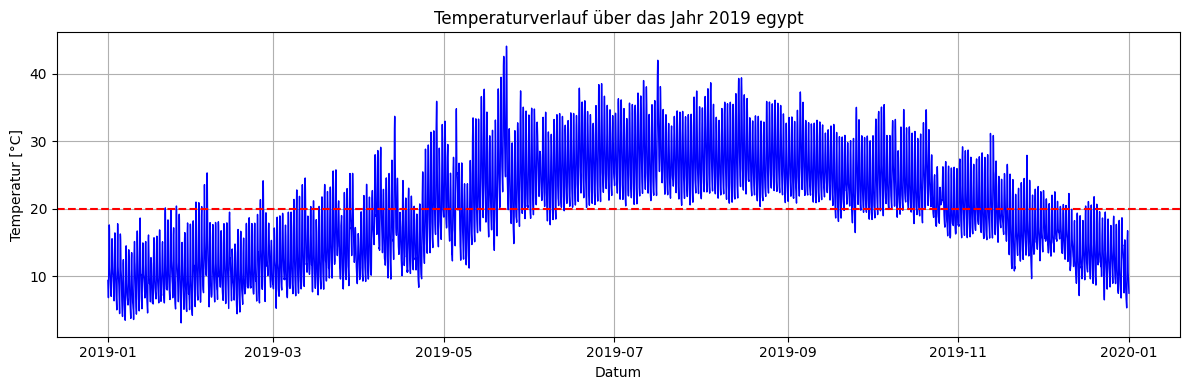

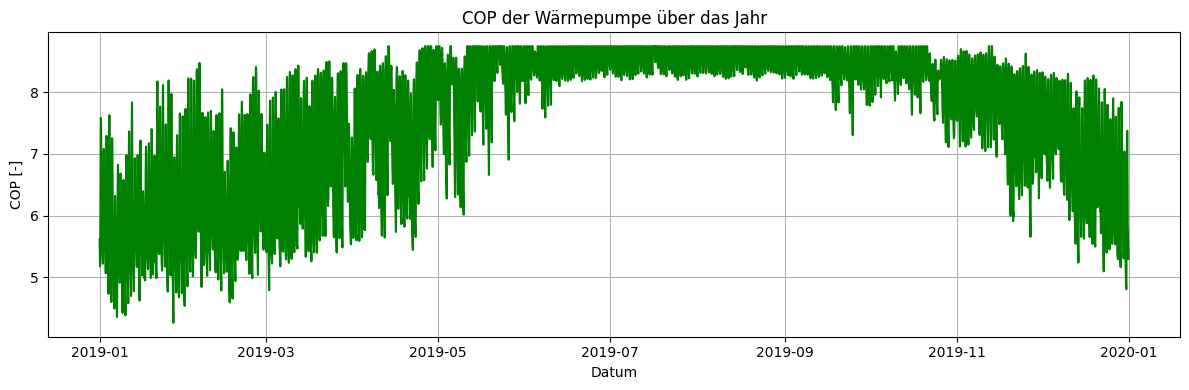

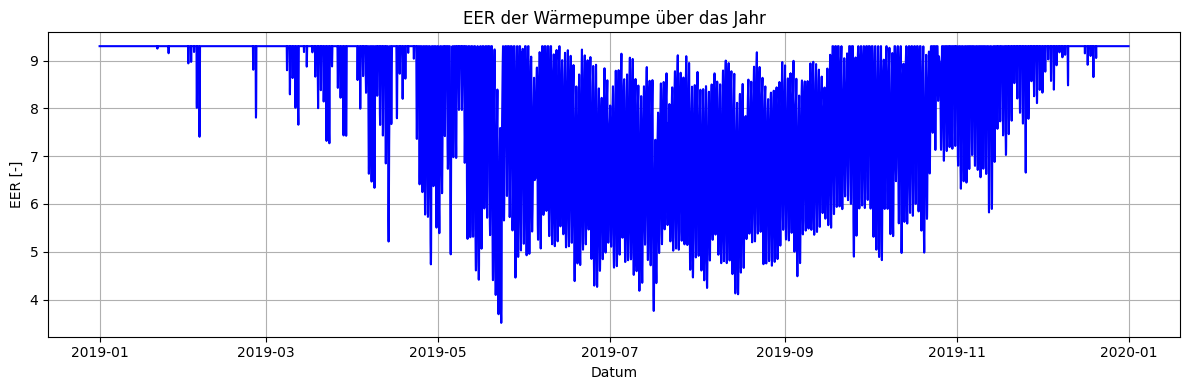

In [1248]:
plt.figure(figsize=(12,4))
plt.plot(temp_profile.index, temp_profile.values, color='blue', linewidth=1)
plt.axhline(y=temp_innen, color='red', linestyle='--', linewidth=1.5, label="Innentemperatur (20°C)")
plt.title(f"Temperaturverlauf über das Jahr 2019 {location}")
plt.xlabel("Datum")
plt.ylabel("Temperatur [°C]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot COP
plt.figure(figsize=(12,4))
plt.plot(df_results.index,COP_interp, color="green")
plt.title("COP der Wärmepumpe über das Jahr")
plt.xlabel("Datum")
plt.ylabel("COP [-]")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot EER
plt.figure(figsize=(12,4))
plt.plot(df_results.index,EER_interp, color="blue")
plt.title("EER der Wärmepumpe über das Jahr")
plt.xlabel("Datum")
plt.ylabel("EER [-]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1249]:
#Solarthermie
eta_col = 0.69 #Kollektorwirkungsgrad bei Delta T = 40K, Vitosol 300 TM
A_kollektor = 1.51 # Kollektorfläche


solar_profile_W = solar_profile * A_kollektor # Solarer Ertrag pro Kollektor in W

solar_th = (solar_profile * eta_col) * A_kollektor # Leistung eines Kollektors inkl. Verlusten in W
solar_p_pu = (solar_th/solar_th.max())
df_results["solar_p_pu"] = solar_p_pu
solar_p_nom_max = round((Grundfläche/A_kollektor)*solar_th.max()/1000,0)
print(solar_p_nom_max,'kW')
print('Maximale Leistung Kollektor:',round(solar_th.max(),2),'W')
print('mean:',round(solar_profile.mean(),2),'W/m2')
print('max:',solar_profile.max(),'W/m2')
print('min:',solar_profile.min(),'W/m2')

44.0 kW
Maximale Leistung Kollektor: 1100.62 W
mean: 254.37 W/m2
max: 1056.361 W/m2
min: 0.0 W/m2


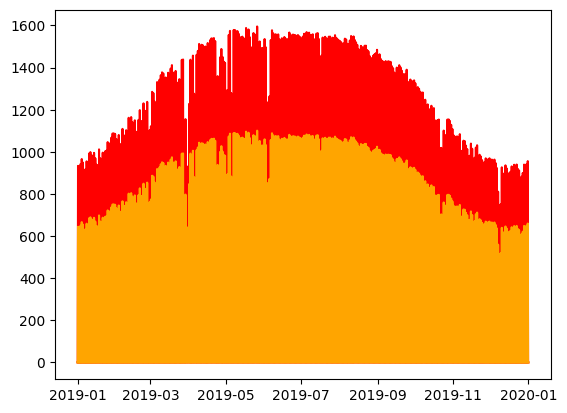

In [1250]:
#Wärmeverlust_kollektor_2.plot()
plt.plot(solar_profile_W, color="red")
plt.plot(solar_th, color="orange")

Gesamter Stromverbrauch [kWh]: 10169.29


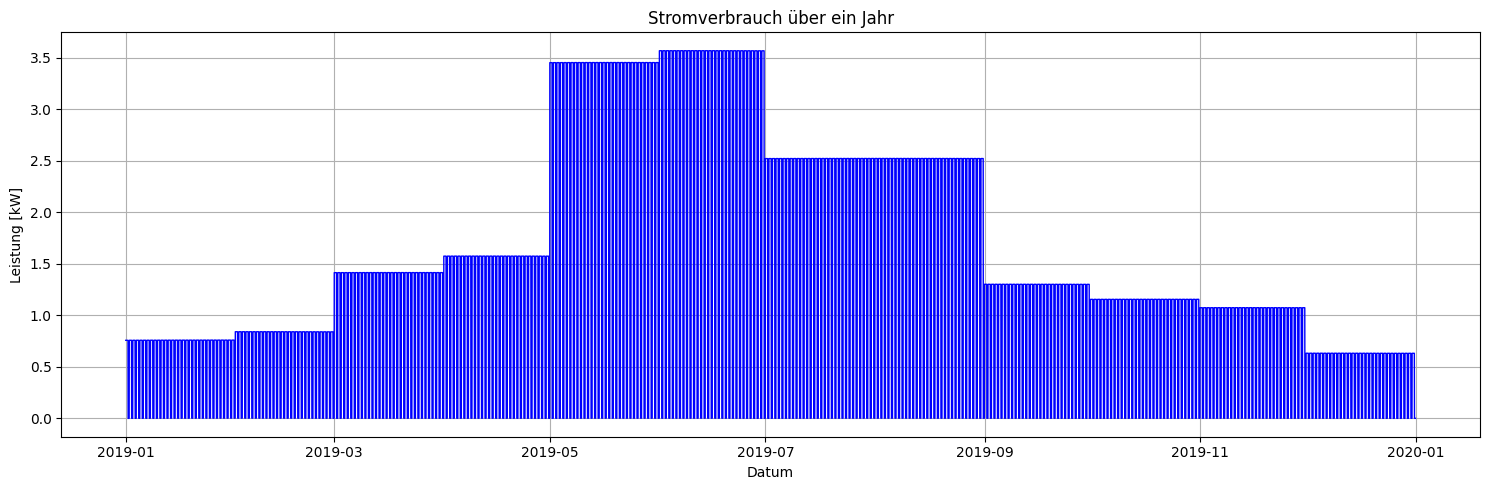

In [1251]:
##### Energiesystem #####
#Pflanzen-Lastprofil laden (Water, Light)
load_profiles = pd.read_csv(profiles2[scenario],index_col=0, parse_dates=True)
electrical_load = (load_profiles["light_kW"] + load_profiles["water_kW"])

print("Gesamter Stromverbrauch [kWh]:", round(electrical_load.sum(),2))

plt.figure(figsize=(15,5))
plt.plot(electrical_load.index, electrical_load.values, color='blue', linewidth=1)
plt.title("Stromverbrauch über ein Jahr")
plt.xlabel("Datum")
plt.ylabel("Leistung [kW]")
plt.grid(True)
plt.tight_layout()
plt.show()


In [1252]:
#df_results["Kältebedarf_kW"][2550:2750].plot()
#df_results["Wärmebedarf_kW"][2550:2750].plot()
#[2550:2750]

In [1253]:
#plt.plot(COP_interp[2550:2750])
#plt.plot(EER_interp[2550:2750])

In [1254]:
def annuity(invest, interest_rate, lifespan):
    return invest * ((1 + interest_rate)**lifespan) * interest_rate / ((1 + interest_rate)**lifespan - 1)

In [1255]:
# ---- Netz aufsetzen ----
network = pypsa.Network()
network.set_snapshots(range(8760))

electrical_load.index = network.snapshots
pv_profile.index = network.snapshots
wind_profile.index = network.snapshots


interest_rate = 0.02

pv_invest = 900 #Fraunhofer ISE
pv_lifespan = 30

wind_invest = 1600 #Fraunhofer ISE
wind_lifespan = 20

battery_invest = 500
battery_lifespan = 15

heatpump_invest = 2000
heatpump_lifespan = 15

heating_rod_invest = 100 #€/kW
heating_rod_lifespan = 20

heat_store_invest = 100 #€/kWh
heat_store_lifespan = 20
thermal_storage_self_discharge = 0.05 # Selbstentladungsverluste in pu pro Stunde

solar_thermal_invest = 500*A_kollektor #€/m2 Kollektorfläche --> € pro Kollektor
solar_thermal_lifespan = 20

pv_annuity = annuity(pv_invest, interest_rate, pv_lifespan)
wind_annuity = annuity(wind_invest, interest_rate, wind_lifespan)
battery_annuity = annuity(battery_invest, interest_rate, battery_lifespan)
heatpump_annuity = annuity(heatpump_invest, interest_rate, heatpump_lifespan)
heating_rod_annuity = annuity(heatpump_invest, interest_rate, heatpump_lifespan)
heat_store_annuity = annuity(heat_store_invest, interest_rate, heat_store_lifespan)
solar_thermal_annuity = annuity(solar_thermal_invest, interest_rate, solar_thermal_lifespan)

########################
network.add("Carrier", "solar")
network.add("Carrier", "wind")
network.add("Carrier", "battery")
network.add("Carrier", "electricity")
network.add("Carrier", "heating")
network.add("Carrier", "cooling")

########################
network.add("Bus", "electricity", carrier="electricity")
network.add('Bus', 'heat', carrier='heating')
network.add('Bus', 'cool', carrier='cooling')

########################
network.add("Load",
            name="Verbrauch ",
            bus="electricity",
            p_set=electrical_load,
            carrier="electricity")

network.add("Load",
            name="heating_load",
            bus='heat',
            p_set=list(df_results["Wärmebedarf_kW"]),
            carrier='heating')

network.add("Load",
            name="cooling_load",
            bus='cool',
            p_set=list(df_results["Kältebedarf_kW"]),
            carrier='cooling')

########################
network.add("Generator",
            name="pv",
            bus="electricity",
            p_max_pu=pv_profile,
            capital_cost=pv_annuity,
            carrier="solar",
            p_nom_extendable=True)

network.add("Generator",
            name="wind",
            bus="electricity",
            p_max_pu=wind_profile,
            capital_cost=wind_annuity,
            carrier="wind",
            p_nom_extendable=True)

network.add("Generator",
            name="solar_thermal_energy",
            bus="heat",
            p_nom_extendable=True,
            p_max_pu=list(df_results["solar_p_pu"]),
            capital_cost  =solar_thermal_annuity,
            active = True)

########################
network.add("Store",
            name="battery",
            bus="electricity",
            e_cyclic=True,  # Anfang = Ende
            e_nom_extendable=True,
            capital_cost=battery_annuity,
            carrier="battery",
            efficiency_store=0.9,
            efficiency_dispatch=0.9)

network.add('Store',
            name = 'Warmwasserspeicher',
            bus = 'heat',
            e_nom_extendable = True,
            e_nom_max = 50,
            standing_loss = thermal_storage_self_discharge,
            capital_cost = heat_store_annuity,
            active = True)

########################
network.add('Link',
            name="Heatpump_heat",
            bus0="electricity",
            bus1="heat",
            p_nom_extendable=True,
            p_max_pu=heat_el_p_pu,
            capital_cost=0.5*heatpump_annuity,
            efficiency=COP_interp,
            active = True)

network.add('Link',
            name="Heatpump_cool",
            bus0="electricity",
            bus1="cool",
            p_nom_extendable=True,
            p_max_pu=cool_el_p_pu,
            capital_cost=0.5*heatpump_annuity,
            efficiency=EER_interp)

network.add('Link',
            name="heating_rod",
            bus0="electricity",
            bus1="heat",
            p_nom_extendable=True,
            capital_cost=heating_rod_annuity,
            efficiency=0.99,
            active = False)


###########################
# Flächenbegrenzung Solarthermie und PV
area_pv = 2.2   # m²/kWp
area_solar_thermal = 1000*A_kollektor/solar_th.max()  # m²/kW, solar_th.max() ist noch in W gegeben

l = network.optimize.create_model()
model_pv_p_nom = l.variables['Generator-p_nom'].at['pv']
model_solar_p_nom = l.variables['Generator-p_nom'].at['solar_thermal_energy']

constraint_expression = model_pv_p_nom * area_pv + model_solar_p_nom * area_solar_thermal <= Grundfläche
l.add_constraints(constraint_expression, name = 'Flächenbegrenzung')

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/linopy/common.py:173: UserWarning:

coords for dimension(s) ['Link-ext'] is not aligned with the pandas object. Previously, the indexes of the pandas were ignored and overwritten in these cases. Now, the pandas object's coordinates are taken considered for alignment.



Constraint `Flächenbegrenzung`
------------------------------
+2.2 Generator-p_nom[pv] + 1.372 Generator-p_nom[solar_thermal_energy] ≤ 60.0

In [1256]:
network.optimize.solve_model(solver_name= 'gurobi')

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 96.32it/s]
INFO:linopy.io: Writing time: 0.45s


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2650217


INFO:gurobipy:Set parameter LicenseID to value 2650217


Academic license - for non-commercial use only - expires 2026-04-11


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-04-11


Read LP format model from file /private/var/folders/_t/dxl0szl17jn4ty4kydwc9kp00000gn/T/linopy-problem-50lk3f60.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/_t/dxl0szl17jn4ty4kydwc9kp00000gn/T/linopy-problem-50lk3f60.lp


Reading time = 0.16 seconds


INFO:gurobipy:Reading time = 0.16 seconds


obj: 166450 rows, 78848 columns, 306972 nonzeros


INFO:gurobipy:obj: 166450 rows, 78848 columns, 306972 nonzeros


Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.6.0 24G84)


INFO:gurobipy:Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (mac64[arm] - Darwin 24.6.0 24G84)


INFO:gurobipy:


CPU model: Apple M1 Pro


INFO:gurobipy:CPU model: Apple M1 Pro


Thread count: 10 physical cores, 10 logical processors, using up to 10 threads


INFO:gurobipy:Thread count: 10 physical cores, 10 logical processors, using up to 10 threads


INFO:gurobipy:


Optimize a model with 166450 rows, 78848 columns and 306972 nonzeros


INFO:gurobipy:Optimize a model with 166450 rows, 78848 columns and 306972 nonzeros


Model fingerprint: 0xc965f2a3


INFO:gurobipy:Model fingerprint: 0xc965f2a3


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [9e-07, 9e+00]


INFO:gurobipy:  Matrix range     [9e-07, 9e+00]


  Objective range  [6e+00, 1e+02]


INFO:gurobipy:  Objective range  [6e+00, 1e+02]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [3e-06, 6e+01]


INFO:gurobipy:  RHS range        [3e-06, 6e+01]


Presolve removed 109264 rows and 38950 columns


INFO:gurobipy:Presolve removed 109264 rows and 38950 columns


Presolve time: 0.10s


INFO:gurobipy:Presolve time: 0.10s


Presolved: 57186 rows, 39898 columns, 175933 nonzeros


INFO:gurobipy:Presolved: 57186 rows, 39898 columns, 175933 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.02s


INFO:gurobipy:Ordering time: 0.02s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 6


INFO:gurobipy: Dense cols : 6


 AA' NZ     : 1.992e+05


INFO:gurobipy: AA' NZ     : 1.992e+05


 Factor NZ  : 9.557e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 9.557e+05 (roughly 50 MB of memory)


 Factor Ops : 1.721e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.721e+07 (less than 1 second per iteration)


 Threads    : 8


INFO:gurobipy: Threads    : 8


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.52847179e+06 -1.79921735e+07  1.01e+04 7.26e-01  3.30e+04     0s


INFO:gurobipy:   0   1.52847179e+06 -1.79921735e+07  1.01e+04 7.26e-01  3.30e+04     0s


   1   1.71523639e+06 -1.69744851e+07  8.65e+03 2.45e+01  2.43e+04     0s


INFO:gurobipy:   1   1.71523639e+06 -1.69744851e+07  8.65e+03 2.45e+01  2.43e+04     0s


   2   2.03178670e+06 -1.91658341e+07  6.56e+03 7.72e+00  1.39e+04     0s


INFO:gurobipy:   2   2.03178670e+06 -1.91658341e+07  6.56e+03 7.72e+00  1.39e+04     0s


   3   8.27355563e+05 -1.79502642e+07  1.19e+03 1.96e+00  2.94e+03     0s


INFO:gurobipy:   3   8.27355563e+05 -1.79502642e+07  1.19e+03 1.96e+00  2.94e+03     0s


   4   6.87952032e+05 -1.12839270e+07  1.73e+02 3.31e-01  5.26e+02     0s


INFO:gurobipy:   4   6.87952032e+05 -1.12839270e+07  1.73e+02 3.31e-01  5.26e+02     0s


   5   5.53450059e+05 -6.71456346e+06  4.21e+01 1.25e-01  1.79e+02     0s


INFO:gurobipy:   5   5.53450059e+05 -6.71456346e+06  4.21e+01 1.25e-01  1.79e+02     0s


   6   3.91744677e+05 -3.69822397e+06  1.39e+01 4.95e-02  7.37e+01     0s


INFO:gurobipy:   6   3.91744677e+05 -3.69822397e+06  1.39e+01 4.95e-02  7.37e+01     0s


   7   1.80733280e+05 -1.01633833e+06  1.34e+00 8.18e-03  1.51e+01     0s


INFO:gurobipy:   7   1.80733280e+05 -1.01633833e+06  1.34e+00 8.18e-03  1.51e+01     0s


   8   7.56008206e+04 -5.40703627e+04  1.98e-01 5.60e-05  1.35e+00     0s


INFO:gurobipy:   8   7.56008206e+04 -5.40703627e+04  1.98e-01 5.60e-05  1.35e+00     0s


   9   1.00529444e+04 -5.72965200e+03  1.52e-02 1.07e-12  1.57e-01     0s


INFO:gurobipy:   9   1.00529444e+04 -5.72965200e+03  1.52e-02 1.07e-12  1.57e-01     0s


  10   5.11309205e+03 -6.42566882e+03  6.48e-03 9.32e-13  1.15e-01     0s


INFO:gurobipy:  10   5.11309205e+03 -6.42566882e+03  6.48e-03 9.32e-13  1.15e-01     0s


  11   2.99054126e+03 -1.16430286e+03  2.74e-03 1.24e-13  4.11e-02     0s


INFO:gurobipy:  11   2.99054126e+03 -1.16430286e+03  2.74e-03 1.24e-13  4.11e-02     0s


  12   2.72173667e+03 -6.66557979e+01  2.32e-03 7.86e-14  2.76e-02     0s


INFO:gurobipy:  12   2.72173667e+03 -6.66557979e+01  2.32e-03 7.86e-14  2.76e-02     0s


  13   2.59869936e+03  2.86046172e+02  2.05e-03 6.22e-14  2.29e-02     0s


INFO:gurobipy:  13   2.59869936e+03  2.86046172e+02  2.05e-03 6.22e-14  2.29e-02     0s


  14   2.05407149e+03  6.08516052e+02  1.21e-03 3.49e-14  1.43e-02     0s


INFO:gurobipy:  14   2.05407149e+03  6.08516052e+02  1.21e-03 3.49e-14  1.43e-02     0s


  15   1.71307116e+03  8.90745264e+02  6.75e-04 2.18e-14  8.13e-03     0s


INFO:gurobipy:  15   1.71307116e+03  8.90745264e+02  6.75e-04 2.18e-14  8.13e-03     0s


  16   1.64809563e+03  1.07193022e+03  5.45e-04 1.42e-14  5.70e-03     1s


INFO:gurobipy:  16   1.64809563e+03  1.07193022e+03  5.45e-04 1.42e-14  5.70e-03     1s


  17   1.52881185e+03  1.26733244e+03  2.35e-04 4.48e-16  2.59e-03     1s


INFO:gurobipy:  17   1.52881185e+03  1.26733244e+03  2.35e-04 4.48e-16  2.59e-03     1s


  18   1.48689325e+03  1.35651039e+03  1.58e-04 1.55e-15  1.29e-03     1s


INFO:gurobipy:  18   1.48689325e+03  1.35651039e+03  1.58e-04 1.55e-15  1.29e-03     1s


  19   1.47224613e+03  1.39156446e+03  1.22e-04 1.60e-16  7.98e-04     1s


INFO:gurobipy:  19   1.47224613e+03  1.39156446e+03  1.22e-04 1.60e-16  7.98e-04     1s


  20   1.44410310e+03  1.41317166e+03  4.58e-05 3.23e-16  3.06e-04     1s


INFO:gurobipy:  20   1.44410310e+03  1.41317166e+03  4.58e-05 3.23e-16  3.06e-04     1s


  21   1.44083023e+03  1.41914687e+03  3.83e-05 1.07e-15  2.15e-04     1s


INFO:gurobipy:  21   1.44083023e+03  1.41914687e+03  3.83e-05 1.07e-15  2.15e-04     1s


  22   1.43732010e+03  1.42292485e+03  2.91e-05 9.99e-15  1.43e-04     1s


INFO:gurobipy:  22   1.43732010e+03  1.42292485e+03  2.91e-05 9.99e-15  1.43e-04     1s


  23   1.43456620e+03  1.42305178e+03  2.06e-05 1.09e-15  1.14e-04     1s


INFO:gurobipy:  23   1.43456620e+03  1.42305178e+03  2.06e-05 1.09e-15  1.14e-04     1s


  24   1.43269358e+03  1.42368649e+03  1.50e-05 4.44e-16  8.91e-05     1s


INFO:gurobipy:  24   1.43269358e+03  1.42368649e+03  1.50e-05 4.44e-16  8.91e-05     1s


  25   1.42926148e+03  1.42464068e+03  3.23e-06 5.07e-16  4.57e-05     1s


INFO:gurobipy:  25   1.42926148e+03  1.42464068e+03  3.23e-06 5.07e-16  4.57e-05     1s


INFO:gurobipy:


Barrier performed 25 iterations in 0.69 seconds (0.77 work units)


INFO:gurobipy:Barrier performed 25 iterations in 0.69 seconds (0.77 work units)


Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:Barrier solve interrupted - model solved by another algorithm


INFO:gurobipy:


INFO:gurobipy:


Solved with dual simplex


INFO:gurobipy:Solved with dual simplex


Extra simplex iterations after uncrush: 4


INFO:gurobipy:Extra simplex iterations after uncrush: 4


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   17176    1.4281970e+03   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:   17176    1.4281970e+03   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 17176 iterations and 0.75 seconds (1.36 work units)


INFO:gurobipy:Solved in 17176 iterations and 0.75 seconds (1.36 work units)


Optimal objective  1.428197011e+03


INFO:gurobipy:Optimal objective  1.428197011e+03
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78848 primals, 166450 duals
Objective: 1.43e+03
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance, Flächenbegrenzung were not assigned to the network.


('ok', 'optimal')

In [1257]:
Fläche_pv = area_pv*network.generators.p_nom_opt["pv"]
Fläche_solar = area_solar_thermal*network.generators.p_nom_opt["solar_thermal_energy"]
print("Fläche PV + Solarthermie", round(Fläche_pv + Fläche_solar,2),'m2')
print("Anteil Dachfläche PV", round(100*Fläche_pv/Grundfläche,2),'%')
print("Anteil Dachfläche Solarthermie", round(100*Fläche_solar/Grundfläche,2),'%')
print("Dachfläche", Grundfläche,'m2')

Fläche PV + Solarthermie 21.57 m2
Anteil Dachfläche PV 35.96 %
Anteil Dachfläche Solarthermie 0.0 %
Dachfläche 60.0 m2


In [1258]:
# ---- Ergebnisse ----
print("\n\033[4mAuslegung der Komponenten:\033[0m")
print("PV-Nennleistung [kWp]:", round(network.generators.p_nom_opt["pv"], 2))
print("Wind-Nennleistung [kW]:", round(network.generators.p_nom_opt["wind"], 2))
print("Batterispeicher-Kapazität [kWh]:", round(network.stores.e_nom_opt["battery"], 2))
print("Pufferspeicher-Kapazität [kWh]:", round(network.stores.e_nom_opt["Warmwasserspeicher"], 2))
#print("Heizstab-Nennleistung [kW]:", round(network.links.p_nom_opt['heating_rod'], 2))
print("Solarthermie-Nennleistung bei max. Einstrahlung [kW]:", round(network.generators.p_nom_opt["solar_thermal_energy"], 2))
print("Anzahl Kollektoren [Stück]:", round(network.generators.p_nom_opt["solar_thermal_energy"]/(solar_th.max()*0.001), 0))
print("Nennleistung Wärmepumpe im Heizbetrieb [kW]:", round(network.links.p_nom_opt['Heatpump_heat'], 2))

print("Nennleistung Wärmepumpe im Kühlbetrieb [kW]:", round(network.links.p_nom_opt['Heatpump_cool'], 2))
print("\n\033[4mLasten:\033[0m")
print("Elektrische Last[kWh]:", round(electrical_load.sum(), 2))
print("Heizlast [kWh]:", round(network.loads_t.p['heating_load'].sum(), 2))
print("Kühllast [kWh]:", round(network.loads_t.p['cooling_load'].sum(), 2))
print("JAZ WP Heat:", round(-1*network.links_t.p1['Heatpump_heat'].sum() / network.links_t.p0['Heatpump_heat'].sum(),2))
print("JAZ WP Cool:", round(-1*network.links_t.p1['Heatpump_cool'].sum() / network.links_t.p0['Heatpump_cool'].sum(),2))


Auslegung der Komponenten:
PV-Nennleistung [kWp]: 9.81
Wind-Nennleistung [kW]: 2.21
Batterispeicher-Kapazität [kWh]: 18.02
Pufferspeicher-Kapazität [kWh]: 0.35
Solarthermie-Nennleistung bei max. Einstrahlung [kW]: 0.0
Anzahl Kollektoren [Stück]: 0.0
Nennleistung Wärmepumpe im Heizbetrieb [kW]: 0.57
Nennleistung Wärmepumpe im Kühlbetrieb [kW]: 0.91

Lasten:
Elektrische Last[kWh]: 10169.29
Heizlast [kWh]: 4403.53
Kühllast [kWh]: 5107.69
JAZ WP Heat: 5.92
JAZ WP Cool: 5.94


In [1259]:
print("Gesamtkosten [€]:", round(network.objective, 2))
print("Jährliche Kosten WP Heizbetrieb [€]:", round(heatpump_annuity*network.links.p_nom_opt['Heatpump_heat'], 2))
print("Jährliche Kosten WP Kühlbetrieb [€]:", round(heatpump_annuity*network.links.p_nom_opt['Heatpump_cool'], 2))

Gesamtkosten [€]: 1428.2
Jährliche Kosten WP Heizbetrieb [€]: 88.58
Jährliche Kosten WP Kühlbetrieb [€]: 141.34


In [1260]:
# Verlauf des Ladezustandes der Batterie über das Jahr
battery_soc_pu = network.stores_t.e["battery"] / network.stores.e_nom_opt["battery"]
battery_soc_percent = battery_soc_pu * 100

'''
plt.figure(figsize=(15,5))
plt.plot(battery_soc_percent.index, battery_soc_percent.values, color="green", linewidth=1)
plt.title("SOC des Batteriespeichers")
plt.xlabel("Zeit [h]")
plt.ylabel("SOC [%]")
plt.grid(True)
plt.tight_layout()
plt.show()
'''

'\nplt.figure(figsize=(15,5))\nplt.plot(battery_soc_percent.index, battery_soc_percent.values, color="green", linewidth=1)\nplt.title("SOC des Batteriespeichers")\nplt.xlabel("Zeit [h]")\nplt.ylabel("SOC [%]")\nplt.grid(True)\nplt.tight_layout()\nplt.show()\n'

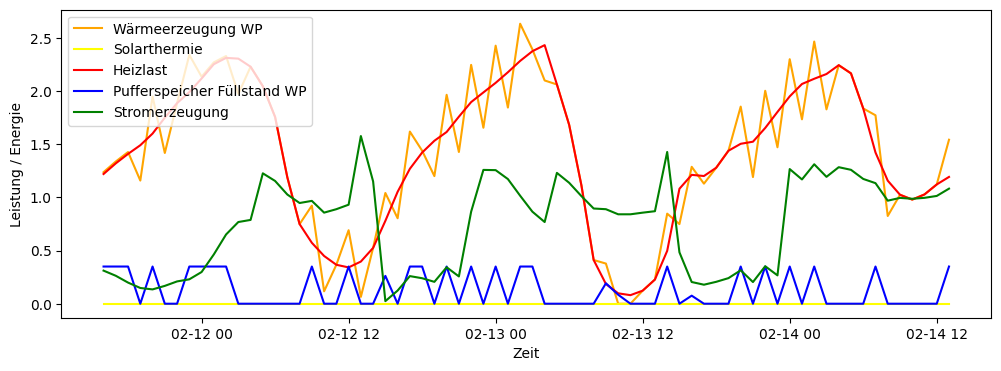

In [1261]:
T1=1000
T2=1070
plt.figure(figsize=(12,4))
plt.plot(df_results.index[T1:T2],-1*network.links_t.p1['Heatpump_heat'][T1:T2], color = 'orange', label ='Wärmeerzeugung WP')
plt.plot(df_results.index[T1:T2],network.generators_t.p['solar_thermal_energy'][T1:T2], color = 'yellow', label ='Solarthermie')
plt.plot(df_results.index[T1:T2],network.loads_t.p['heating_load'][T1:T2], color = 'red', label ='Heizlast')
plt.plot(df_results.index[T1:T2],network.stores_t.e["Warmwasserspeicher"][T1:T2], color = 'blue', label ='Pufferspeicher Füllstand WP')
plt.plot(df_results.index[T1:T2],network.generators_t.p['pv'][T1:T2]+network.generators_t.p['wind'][T1:T2], color = 'green', label ='Stromerzeugung')

plt.legend(loc="upper left")
plt.xlabel("Zeit")
plt.ylabel("Leistung / Energie")
plt.show()

In [1262]:
kosten_dict = {
"PV": network.generators.p_nom_opt["pv"] * network.generators.capital_cost["pv"],
"Wind": network.generators.p_nom_opt["wind"] * network.generators.capital_cost["wind"],
"Solarthermie": network.generators.p_nom_opt["solar_thermal_energy"] * network.generators.capital_cost["solar_thermal_energy"],
"Batterie": network.stores.e_nom_opt["battery"] * network.stores.capital_cost["battery"],
"Pufferspeicher": network.stores.e_nom_opt["Warmwasserspeicher"] * network.stores.capital_cost["Warmwasserspeicher"],
"WP Heat": network.links.p_nom_opt["Heatpump_heat"] * network.links.capital_cost["Heatpump_heat"],
"WP Cool": network.links.p_nom_opt["Heatpump_cool"] * network.links.capital_cost["Heatpump_cool"],
}

df_gesamkosten = pd.DataFrame.from_dict(kosten_dict, orient="index", columns=[scenario])
csv_path = f"./Results_scenario_{export_folder}/Kosten_{scenario}_{location}.csv"
if export_active:
    df_gesamkosten.to_csv(csv_path)
    print(f"CSV exportiert nach: {csv_path}")
else:
    print("CSV Export deaktiviert.")

CSV Export deaktiviert.


In [1263]:
df_gesamkosten

,120
PV,394.071488
Wind,215.937909
Solarthermie,0.000000
Batterie,701.091863
Pufferspeicher,2.138044
WP Heat,44.289587
WP Cool,70.668120


In [1264]:
print("Nutzungsgrad Wind", round(100*wind_profile.sum()/(8760),2),"%")
print("Nutzungsgrad PV", round(100*pv_profile.sum()/(8760),2),"%")

Nutzungsgrad Wind 34.89 %
Nutzungsgrad PV 21.63 %


In [1265]:
summe = electrical_load.sum() + network.links_t.p0['Heatpump_heat'].sum() + network.links_t.p0['Heatpump_cool'].sum()
print("Anteil Strom für Heating + Cooling [%]", round(100*(network.links_t.p0['Heatpump_heat'].sum() + network.links_t.p0['Heatpump_cool'].sum())/summe,2))
print("Anteil Strom für Nutrition [%]", round(100*electrical_load.sum()/summe,2))


Anteil Strom für Heating + Cooling [%] 13.7
Anteil Strom für Nutrition [%] 86.3


In [1266]:
print("Heizlast [kWh]:", round(network.loads_t.p['heating_load'].sum(), 2))
print("Kühllast [kWh]:", round(network.loads_t.p['cooling_load'].sum(), 2))

Heizlast [kWh]: 4403.53
Kühllast [kWh]: 5107.69
